In [1]:
%matplotlib inline
import sys
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl
from prf_net import PRF
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module '_yaml' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def contiguous_ranges(input, return_indices=False):
    """Finds contiguous regions of the array "input". Returns
    a list of ranges with the start and end index of each region. Code based on:
    https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array/4495197
    """

    # Find the indices of changes in "condition"
    d = np.diff(input)
    nz, = d.nonzero() 

    print(nz)
    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the ranges by 1 to the right.
    nz += 1
    nz = np.concatenate([nz, [input.size]])
    
    ranges = np.vstack([ [nz[ri], nz[ri+1]] for ri in range(nz.size-1) ])
    ranges = np.vstack([[0, nz[0]], ranges])

    # Reshape the result into two columns
    ranges.shape = (-1,2)

    if return_indices:
        result = ( np.arange(*r) for r in ranges )
    else:
        result = ranges

    return result

In [3]:
dof_input_matrix = np.asarray(np.load("dof_array.npy"), dtype=np.float32)
print(dof_input_matrix.shape)
cnt_input_matrix = np.asarray(np.load("cnt_array.npy"), dtype=np.float32)
print(cnt_input_matrix.shape)

(4096, 669)
(4096, 669)


In [4]:
n_steps = 100
n_trials = 3
input_matrix = np.vstack((dof_input_matrix, cnt_input_matrix))
normed_input_matrix = input_matrix / np.max(input_matrix)
train_data = np.tile(np.repeat(normed_input_matrix[:,:180], n_steps, axis=1), (1, n_trials))
print(train_data.shape)
print(np.max(train_data))


(8192, 54000)
1.0


In [5]:
def array_input(input_matrix, dt, t, *args):
    i = int(t/dt)
    if i >= input_matrix.shape[1]:
        i = -1
    return input_matrix[:,i]

In [6]:
N_Outputs = 1000
N_Exc = train_data.shape[0]
N_Inh = int(N_Exc/4)

dt = 0.001
srf_seed = 19
t_end = train_data.shape[1] * dt
print(f't_end = {t_end}')
srf_network = PRF(exc_input_func = partial(array_input, train_data, dt),
                  
                  connect_exc_inh_input = True,
#                  connect_inh_inh_input = True,
                  
                  n_excitatory = N_Exc,
                  n_inhibitory = N_Inh,
                  n_outputs = N_Outputs,
                  isp_target_rate = 1.0,
                  
                  
#                  w_initial_E = 0.01,
#                  w_initial_EI = 0.002,
#                  w_EI_Ext = 0.002,
#                  w_initial_I = -0.01,
                  p_E = 0.15,
                  p_EE = 0.05,
                  p_EI_Ext = 0.172,
                  
                  tau_E = 0.05,
                  tau_I = 0.1,
                  learning_rate_I=0.01,
                  learning_rate_E=0.055,
                  
#                  w_initial_E = 0.003,
#                  w_initial_EI = 0.008,
#                  w_EI_Ext = 0.0086,
#                  w_initial_I = -0.05,
#                  p_E = 0.163,
#                  p_EE = 0.35,
#                  p_EI_Ext = 0.172,
                  
#                  tau_E = 0.049,
#                  tau_I = 0.098,
#                  learning_rate_I=0.001,
#                  learning_rate_E=0.055,

                  p_EI = 0.4,
                  tau_input = 0.1,
                  label="Spatial receptive field network",
                  seed=srf_seed)



t_end = 54.0


In [7]:

with srf_network:
    p_output_spikes = nengo.Probe(srf_network.output.neurons, synapse=None)
    p_exc_rates = nengo.Probe(srf_network.exc.neurons)
    p_inh_rates = nengo.Probe(srf_network.inh.neurons)
    p_inh_weights = nengo.Probe(srf_network.conn_I, 'weights', sample_every=10.0)
    p_exc_weights = nengo.Probe(srf_network.conn_E, 'weights', sample_every=10.0)
    if srf_network.conn_EE is not None:
        p_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights', sample_every=10.0)
        
with nengo.Simulator(srf_network, optimize=True) as sim:
    sim.run(np.max(t_end))
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/igr/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [8]:
output_spikes = sim.data[p_output_spikes]

exc_rates = sim.data[p_exc_rates]
inh_rates = sim.data[p_inh_rates] 
exc_weights = sim.data[p_exc_weights]
inh_weights = sim.data[p_inh_weights] 


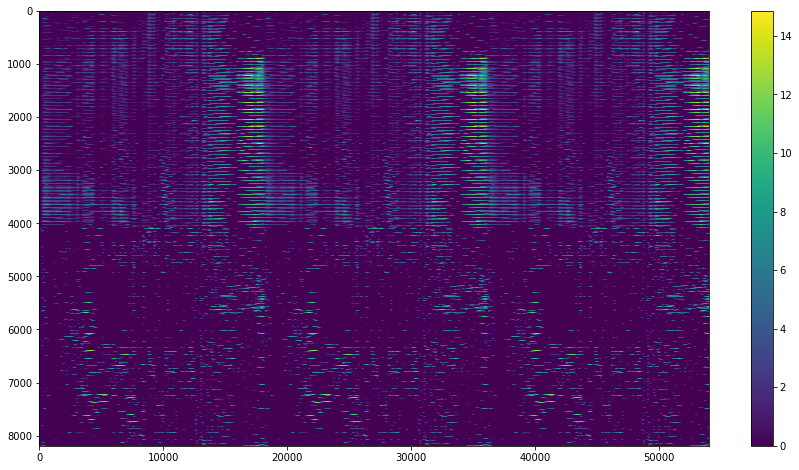

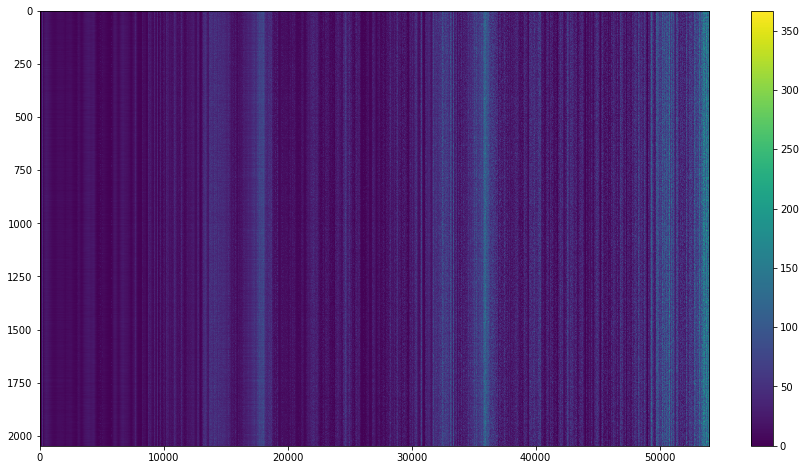

In [9]:
plt.figure(figsize=(15,8))
plt.imshow(exc_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
plt.imshow(inh_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


1.7739011136993004


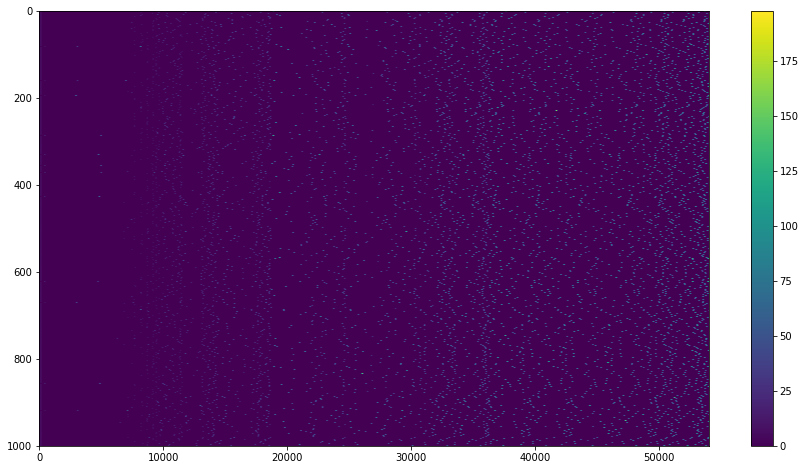

In [10]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


3.4561999266105614


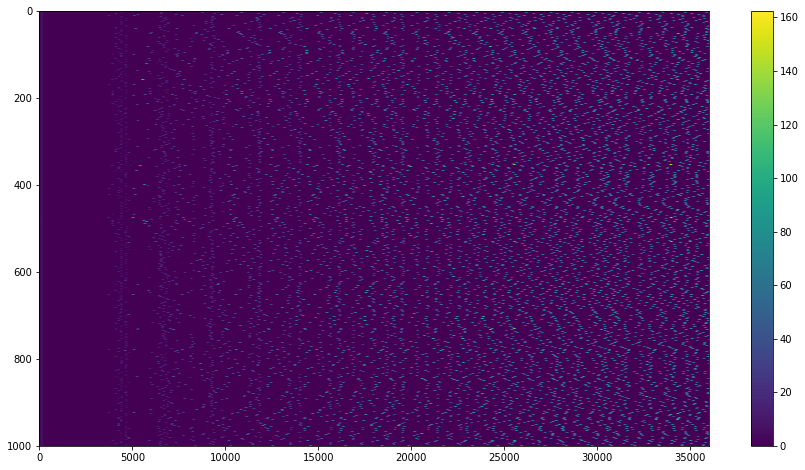

In [10]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


7.49514376284717


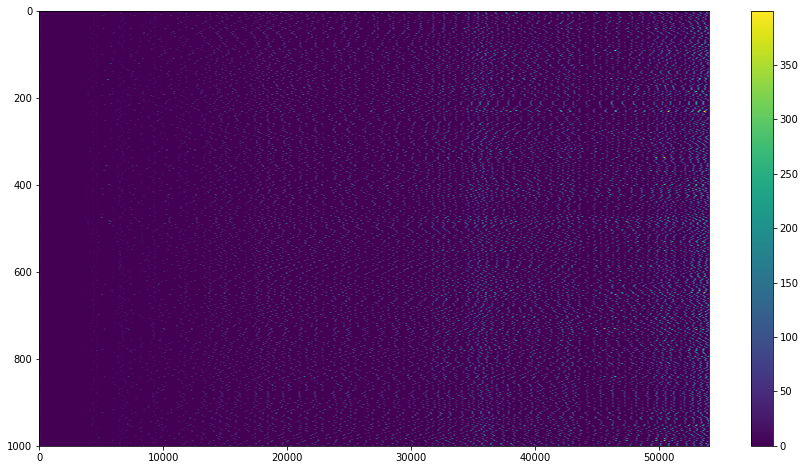

In [10]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


1.7739011136993004


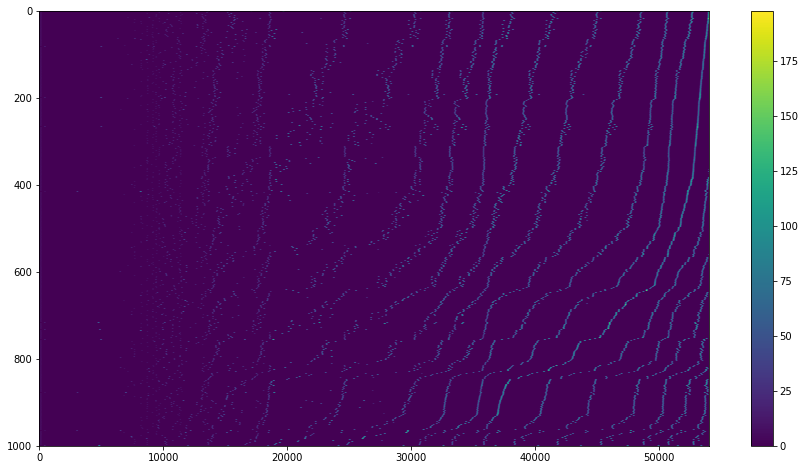

In [11]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates.T, axis=1))
plt.imshow(output_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


7.49514376284717


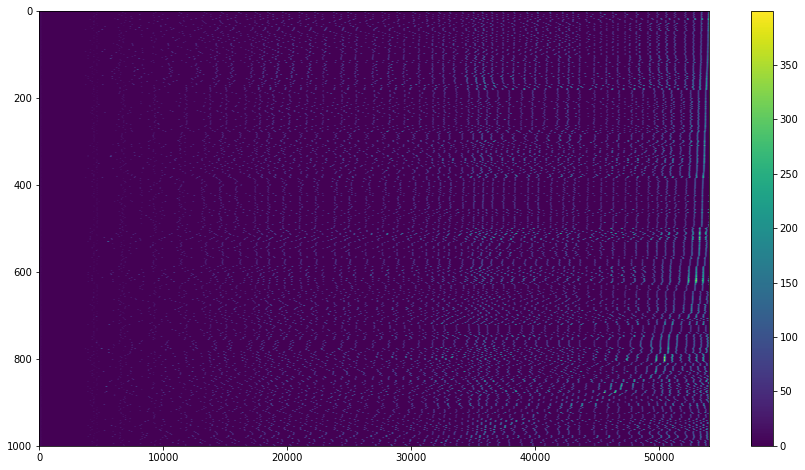

In [12]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates.T, axis=1))
plt.imshow(output_rates[:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


1.7739011136993004


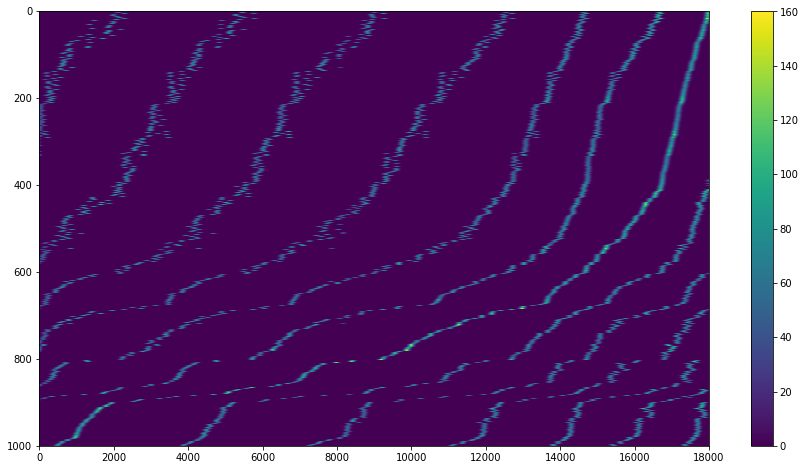

In [12]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[36000:].T, axis=1))
plt.imshow(output_rates[36000:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


7.49514376284717


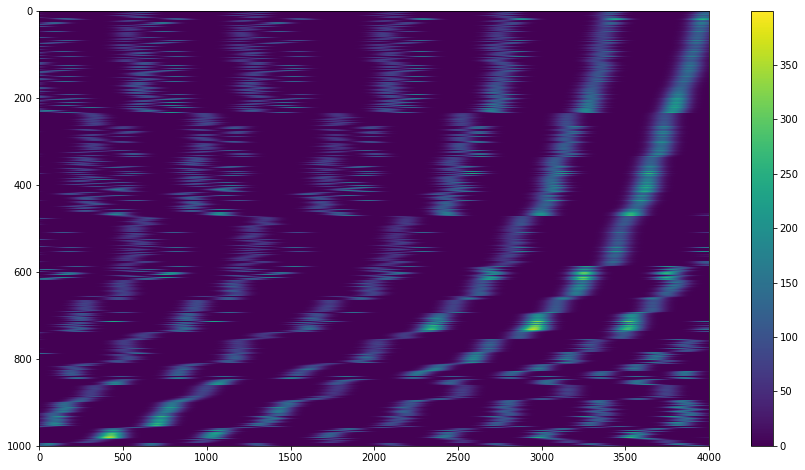

In [14]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[50000:].T, axis=1))
plt.imshow(output_rates[50000:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))
